
## Condizioni iniziali:
1. Ho delle immagini nrrd di **N** pazienti
2. Definisco una lista di **M** trasformazioni MONAI per effettuare l'augmentation di queste immagini (Rotazione, scaling eccetera)
3. Impongo un batch size uguale a **K**
4. Impongo che deve leggere **J** pazienti per volta dal disco

## Procedimento:
1. Leggo J pazienti tra gli N che ho, in modo casuale
2. Applico a tutti i J pazienti le M trasformazioni, arrivando così a **(J*M)+J** immagini (J pazienti non aumentati + (J*M) aumentati)
3. Faccio lo shuffle delle (J*M)+J immagini
4. Fornisco i (J*M)+J  casi che ho ottenuto a blocchi di K 
5. Quando ho passato tutti i (J*M)+J pazienti a blocchi di K, leggo altri J pazienti e ripeto dal punto 2 fino a quando non ho letto tutti gli N pazienti.

In [32]:
import matplotlib.pyplot as plt
from monai.visualize import matshow3d
import numpy as np

def save_subplot(image, path, image_count) -> None:
    first_channel = image[0]
    central_slice_idx = first_channel.shape[1] // 2  # Estraggo l'indice della fetta centrale sul primo canale
                        
    # Seleziona le fette centrali per ciascuna dimensione scalandole tra 0 ed 1
    slice_x = image[:, :, central_slice_idx]
    slice_y = image[:, central_slice_idx, :]
    slice_z = image[central_slice_idx, :, :]

    # Visualizzazione del volume 3D dell'immagine utilizzando matshow3d di MONAI
    fig = plt.figure()
    matshow3d(
        volume=[slice_z, slice_y, slice_x],
        fig=None,
        title=f"Augmented image n. {image_count} for the current block",
        figsize=(10, 10),
        # every_n=10,
        frame_dim=-1,
        show=False,
        cmap="gray",
    )
    plt.savefig(path)
    return None

In [37]:
import torch
import os
import random
from monai.data import ImageDataset
# from AugmentedDataLoaderUtils import save_sublot, zero_one_scaling
"""
Inizializza il dataset e genera i batch utilizzando il metodo 'generate_batches'. 
Dopo aver creato un'istanza di AugmentedDataLoader con i parametri necessari, utilizzare il metodo generate_batches() per iterare sui batch di dati.
    - dataset -> Dataset di tipo ImageDataset, contiene: immagini, etichette e trasformazioni sistematiche
    - augmentation_transforms -> Lista di (M) trasformazioni MONAI per l'augmentation
    - batch_size -> Dimensione del batch (K) ovvero i blocchi da restituire
    - num_patients -> Numero totale di pazienti (N)
    - subset_len -> Lunghezza del subset (J)
    - [optional] transformation_device ->  se indicato, è il dispositivo su cui l'utente sceglie di indirizzare la trasformazione
    - [optional] return_device -> se indicato, è il dispositivo su cui l'utente sceglie di indirizzare ogni batch restituito
    - [optional] debug_path -> se indicato, è il path dove l'utente sceglie di salvare una fetta dell'immagine, per ogni immagine dei batch restituiti 
"""

class AugmentedDataLoader:
    def __init__(
        self,
        dataset: ImageDataset,
        augmentation_transforms: list,
        batch_size: int,
        subset_len: int,
        transformation_device: str = "cpu",
        return_device: str = "cpu",
        debug_path: str = None,
    ):
        self.dataset = dataset  # Dataset di tipo ImageDataset, contiene: immagini, etichette e trasformazioni sistematiche
        self.augmentation_transforms = augmentation_transforms  # Lista di (M) trasformazioni MONAI per l'augmentation
        self.batch_size = batch_size  # Dimensione del batch (K)
        self.num_patients = len(dataset.image_files)  # Numero totale di pazienti (N)
        self.subset_len = subset_len  # Lunghezza del subset (J)
        self.debug_path = debug_path  # se indicato, è il path dove l'utente sceglie di salvare una fetta dell'immagine, per ogni immagine dei batch restituiti
        self.transformation_device = transformation_device # se indicato, è il dispositivo su cui l'utente sceglie di indirizzare la trasformazione
        self.return_device = return_device # se indicato, è il dispositivo su cui l'utente sceglie di indirizzare ogni batch restituito
        self.has_segmentations = bool(dataset.seg_files) # per non trasformare le etichette

    def __iter__(self):
        if self.dataset is None:
            raise Exception("Dataset is None")

        if (
            self.dataset.image_files
            and self.dataset.seg_files
            and len(self.dataset.image_files) != len(self.dataset.seg_files)
        ):
            raise Exception("The length of the images and segmentations don't match")

        # Creo una lista contenente tutti gli indici dei pazienti ed applico lo shuffle per non operare sui pazienti nello stesso ordine di arrivo
        shuffle_patient_indices = list(range(self.num_patients))
        random.shuffle(shuffle_patient_indices)

        index = 0
        while index < self.num_patients:
            """
            ***checked_subset_len*** determina la lunghezza del subset che sarà estratto,
            se il valore specificato dall'utente per subset_len è maggiore del numero di pazienti rimanenti,
            allora subset_len sarà pari al numero di pazienti rimanenti, in modo da evitare di superare la lunghezza della lista dei pazienti
            """
            remaining_patients = self.num_patients - index
            checked_subset_len = min(self.subset_len, remaining_patients)

            """
            Viene creato un subset di pazienti (che vengono scelti dalla lista di indici precedentemente mischiati) avente lunghezza J
            """
            subset_indices = shuffle_patient_indices[index : index + checked_subset_len]
            subset = torch.utils.data.Subset(self.dataset, subset_indices)
            
            augmented_subset = []
            for data in subset:
                augmented_data = []
                for transformation in self.augmentation_transforms:
                    # print(f"applico la trasformazione {transformation}")
                    if(self.transformation_device != "cpu"):
                        print(f"device diverso da cpu trovato: {self.transformation_device}")
                        torch.cuda.set_device(self.transformation_device)

                    # print(f"Shape img: {data[0].shape} - Shape seg: {data[1].shape}")
                    augmented_image = transformation(data[0])
                    # trasformo solo se non è etichetta
                    augmented_segmentation = transformation(data[1]) if self.has_segmentations else data[1]
                    
                    augmented_data.append((augmented_image, augmented_segmentation))

                augmented_subset.append((data[0], data[1]))  # Aggiungo le immagini NON aumentate
                augmented_subset.extend(augmented_data)  # Aggiungo le immagini aumentate

            """
            Ulteriore shuffle delle (J*M)+J immagini, in questo modo riceverà immagini aumentate e non aumentate mixate
            """
            full_batch_indices = torch.randperm(len(augmented_subset))
            augmented_subset = [(augmented_subset[idx][0], augmented_subset[idx][1]) for idx in full_batch_indices]

            """
            Creo blocchi di dimensione K
            - range(0, len(augmented_subset), self.batch_size): 
                genera una sequenza di valori che rappresentano gli indici di inizio di ogni blocco. 
                Gli indici partono da 0 e avanzano con un passo pari a self.batch_size, fino a raggiungere la lunghezza totale di augmented_subset.
            - augmented_subset[i:i + self.batch_size]: 
                seleziona una sotto-lista di augmented_subset che va dall'indice i fino all'indice i + self.batch_size. 
                Questo crea un blocco di immagini di dimensione self.batch_size.
            """
            blocks = [
                augmented_subset[i : i + self.batch_size]
                for i in range(0, len(augmented_subset), self.batch_size)
            ]

            # for img, seg in augmented_subset:
            #     save_subplot(img, './')
            
            image_count = 0
            for block in blocks:
                """
                Restituisco i blocchi di dimensione K.
                Per ogni blocco, viene creato un tensore batch utilizzando la funzione stack di torch che concatena i tensori all'interno del blocco lungo la dimensione 0,
                creando così un unico tensore che rappresenta un batch di immagini.
                Operatore yield per mantenere lo stato della funzione tra le chiamate.
                """
                if self.debug_path:
                    for i, data in enumerate(block):
                        print(f"data[0] {data[0].shape} - data[1] {data[1].shape if hasattr(data[1], '__len__') else data[1]}")
                        image = data[0] 
                        debug_image_path = os.path.join(self.debug_path, f"augmented_image_{image_count}.png")
                        save_subplot(image=image, path=debug_image_path, image_count=image_count)
                        
                        image_count += 1

                float_block = []        
                for tensor_tuple in block:
                    float_img = tensor_tuple[0].float()
                    float_seg = tensor_tuple[1].float() if self.has_segmentations else tensor_tuple[1]
                    float_block.append([float_img,float_seg])  # Conversione dei tensori delle immagini e segmentazioni a float32

                images = torch.stack([data[0] for data in float_block]).to(self.return_device)
                segmentations_or_labels = torch.stack([data[1] for data in float_block]).to(self.return_device) if self.has_segmentations else [data[1] for data in float_block]
                
                yield images, segmentations_or_labels

            """
            Dopo aver passato tutti i (J*M)+J pazienti a blocchi di K, incremento l'indice e riparto per leggere altri J pazienti
            """
            index += checked_subset_len

il dataset ha le segmentazioni False
data[0] torch.Size([512, 300, 300, 1]) - data[1] 1
data[0] torch.Size([512, 300, 300, 1]) - data[1] 1
data[0] torch.Size([512, 300, 300, 1]) - data[1] 1
Totale immagini: 5
Totale trasformazioni: 2
Grandezza batch richiesta: 2
Blocchi ricevuti: 2


<Figure size 640x480 with 0 Axes>

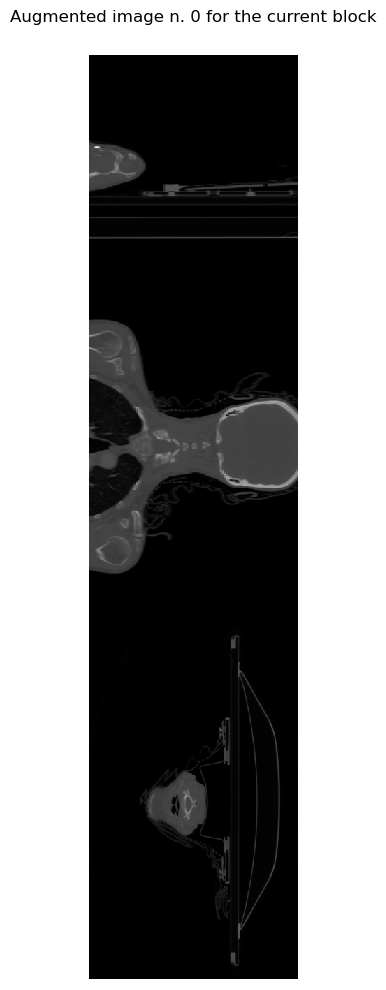

<Figure size 640x480 with 0 Axes>

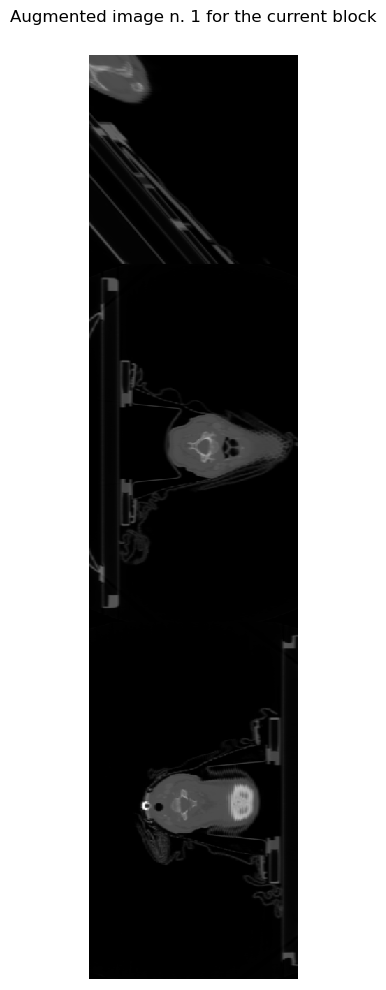

<Figure size 640x480 with 0 Axes>

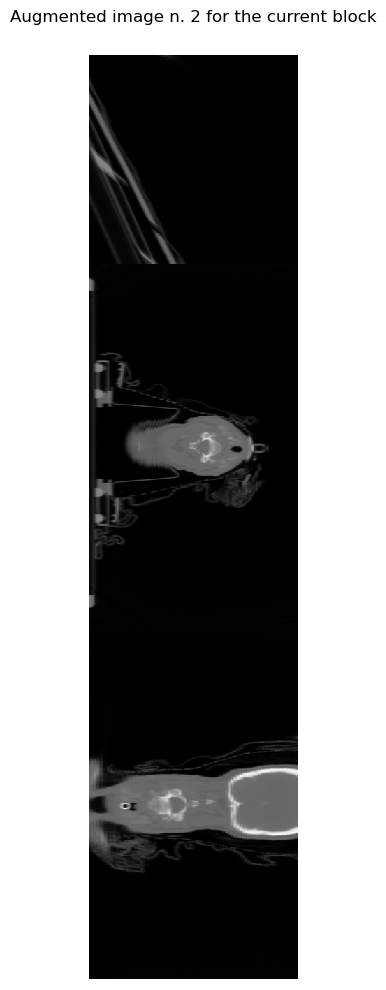

In [40]:
from monai.transforms import Rotate, Compose, Resize

# ImageDataset params
images_to_transform = [
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0001/img.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0002/img.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0003/img.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0009/img.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0013/img.nrrd",
]

seg_to_transform = [
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0001/structures/BrainStem.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0002/structures/BrainStem.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0003/structures/BrainStem.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0009/structures/BrainStem.nrrd",
    "./benchmark/data/PDDCA-1.4.1_part1/0522c0013/structures/BrainStem.nrrd",
]
labels=[1,0]
each_image_trans = Compose([Resize([300,300,1])])

# AugmentedDataLoader params
augmentation_transforms = [
    Rotate(angle=26),
    Rotate(angle=20),
]
batch_size = 2
debug_path='./benchmark/data/debug_path_test'

# dataset = ImageDataset(image_files=images_to_transform, seg_files=seg_to_transform, transform=each_image_trans, seg_transform=each_image_trans) # test solo segmentazioni
dataset = ImageDataset(image_files=images_to_transform, labels=[1,0], transform=each_image_trans) # test solo etichette
# dataset = ImageDataset(image_files=images_to_transform, seg_files=seg_to_transform, labels=[1,0], transform=each_image_trans, seg_transform=each_image_trans) # test etichette e segmentazioni

augmented_data_loader = AugmentedDataLoader(dataset=dataset, augmentation_transforms=augmentation_transforms, batch_size=batch_size, subset_len=2, debug_path=debug_path) # con debug
# augmented_data_loader = AugmentedDataLoader(dataset, augmentation_transforms, batch_size, 2) # senza debug

blocks = 0
for batch_data in augmented_data_loader:
        inputs, labels = batch_data[0], batch_data[1]
        # print(labels)
        blocks+=1

print(f"Totale immagini: {len(images_to_transform)}")
print(f"Totale trasformazioni: {len(augmentation_transforms)}")
print(f"Grandezza batch richiesta: {batch_size}")
print(f"Blocchi ricevuti: {blocks}")